# Dense Neural Network

* Here we are dealing with the most basic neural network. 
The network contains two hidden Dense Neural Networks.

* We use Standard Scaling for input(X) and Mean-Max Scaling for output(Y). Tanh is used as the output activation function. 

* 12th label parameter (one of the Dihedral angles) had some issues which is fixed. 

* IQR method is used to remove outliers.


# Data Augmentation using FFT
I was experimenting with the data by taking its fourier transform to see if it captures the labels better than its original counterpart. 

In [1]:
import numpy as np # linear algebra
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization, Input
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Output_data_ML.npy')

X=X.astype(np.float64)
Y=Y.astype(np.float64)

print(np.shape(X),np.shape(Y))
X.dtype, Y.dtype

(1070107, 38) (15, 1070107)


(dtype('float64'), dtype('float64'))

* I have applied a PCA to the scattering data to remove those components that do not make a difference. (Didn't like the idea)
* I have applied a log on the degrees of freedom to reduce the skewness in the data 
* Float32 to Float64
* I have removed some of the points using the IQR method. (Done)
* I have removed the negative values of the dihedral angles and multiply the bond distances by 10 to get numbers in the same orders as the bonds/dihedrals 
* I have taken 900K data points to train and I have applied
a standard scaler over them. (Done)

In [4]:
pca=PCA(n_components=20)
X=pca.fit_transform(X)

scaler2 =StandardScaler()
X=scaler2.fit_transform(X)

In [5]:
Y=Y.T
Y[:,6:]=Y[:,6:]%(2*np.pi)

y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std

#Y=np.log(Y)

R=np.array([i for i in range(Y.shape[0])])
np.random.shuffle(R)
X=X[R,:]
Y=Y[R,:]  

Q1=np.quantile(Y,0.10,axis=0)
Q3=np.quantile(Y,0.90,axis=0)
IQR=Q3-Q1
X=X[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]
Y=Y[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

'''
#Re-Normalization is the worst idea. 
print(np.mean(Y,axis=0),np.std(Y,axis=0))
y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std
'''
print(np.mean(Y,axis=0),np.std(Y,axis=0))

(818880, 20) (818880, 15) (204720, 20) (204720, 15)
[ 0.00367391  0.00301703  0.00192874  0.00272646  0.00344894  0.00312251
 -0.02518176  0.01479297 -0.0200592  -0.02218453 -0.00711926  0.00922037
  0.15577354 -0.14126018  0.10889032] [0.21967639 0.22145078 0.23628999 0.21217199 0.21382921 0.18725208
 0.99315809 0.98468965 0.99251663 0.99288506 0.99478313 1.00079107
 0.29176488 0.29879649 0.27264246]


In [6]:
key=np.random.randint(np.shape(X)[0],size=1000)
X=X[key]
Y=Y[key]

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

(800, 20) (800, 15) (200, 20) (200, 15)


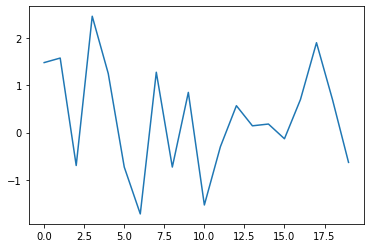

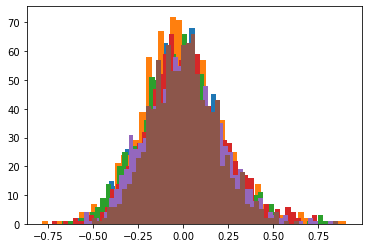

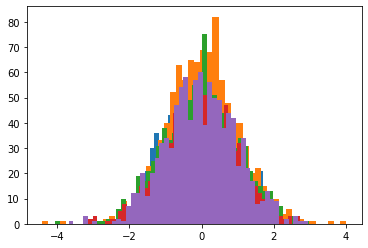

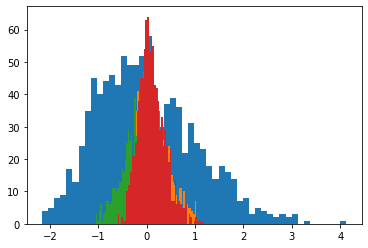

In [7]:
plt.plot(X[100,:])
plt.show()
for i in range(6):
    plt.hist(Y[:,i],bins=50)
plt.show()
for i in range(6,11):
    plt.hist(Y[:,i],bins=50)
plt.show()
for i in range(11,15):
    plt.hist(Y[:,i],bins=50)
plt.show()

In [8]:
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(20,)))
#model.add(LeakyReLU(alpha=.1))
#model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Dense(50, activation='relu'))
#model.add(LeakyReLU(alpha=.1))
#model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Dense(50, activation='relu'))
#model.add(LeakyReLU(alpha=.1))
#model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Dense(15, activation='linear')) #tanh 

In [9]:
model.compile(loss='mse', optimizer = Adam(lr=1e-3), metrics=["accuracy"])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                765       
Total params: 6,915
Trainable params: 6,915
Non-trainable params: 0
_________________________________________________________________


In [10]:
hist = model.fit(x=xtrain, y=ytrain, batch_size=512,
                epochs=200, 
                verbose=1,  #1 for ETA, 0 for silent
                validation_data=(xtest, ytest), 
                callbacks=[annealer])

Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 358us/step - loss: 0.5507 - accuracy: 0.1200 - val_loss: 0.5148 - val_accuracy: 0.1250
Epoch 2/200
800/800 [==============================] - 0s 15us/step - loss: 0.5128 - accuracy: 0.1125 - val_loss: 0.4889 - val_accuracy: 0.1400
Epoch 3/200
800/800 [==============================] - 0s 14us/step - loss: 0.4848 - accuracy: 0.1050 - val_loss: 0.4701 - val_accuracy: 0.1250
Epoch 4/200
800/800 [==============================] - 0s 15us/step - loss: 0.4640 - accuracy: 0.1050 - val_loss: 0.4558 - val_accuracy: 0.0800
Epoch 5/200
800/800 [==============================] - 0s 12us/step - loss: 0.4495 - accuracy: 0.1050 - val_loss: 0.4451 - val_accuracy: 0.0950
Epoch 6/200
800/800 [==============================] - 0s 15us/step - loss: 0.4378 - accuracy: 0.0950 - val_loss: 0.4369 - val_accuracy: 0.0850
Epoch 7/200
800/800 [==============================] - 0s 15us/step - loss: 0.4285 - accu

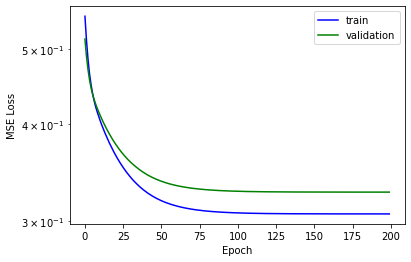

In [11]:
plt.semilogy(hist.history['loss'], color='b',label='train')
plt.semilogy(hist.history['val_loss'], color='g',label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [12]:
Y_hat=model.predict(xtest)

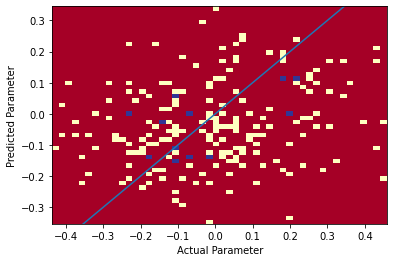

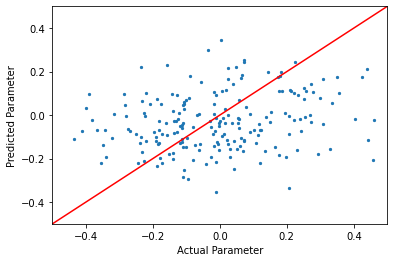

In [18]:
plt.hist2d(ytest[:,0],Y_hat[:,0],bins=50,cmap=cm.RdYlBu)
plt.xlabel('Actual Parameter')
plt.ylabel('Predicted Parameter')
plt.plot(np.arange(-1,1,0.01),np.arange(-1,1,0.01))
plt.show()

plt.scatter(ytest[:,0],Y_hat[:,0],s=5)
plt.xlabel('Actual Parameter')
plt.ylabel('Predicted Parameter')
plt.ylim(-0.5,0.5)
plt.xlim(-0.5,0.5)
plt.plot(np.arange(-1,1,0.01),np.arange(-1,1,0.01),c='r')
plt.show()

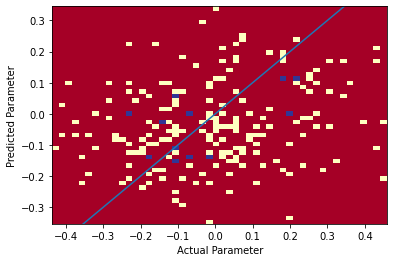

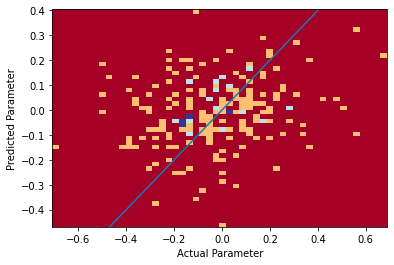

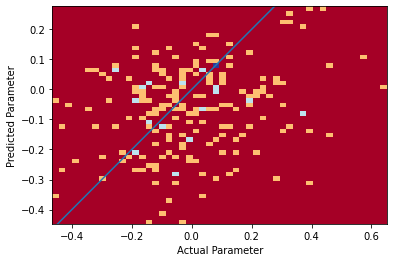

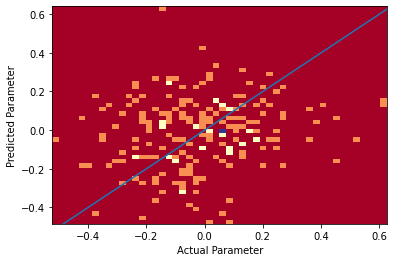

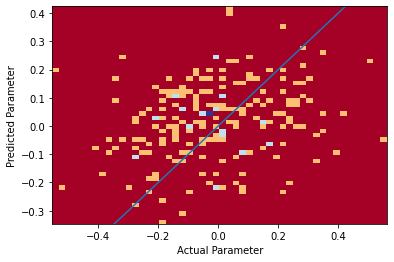

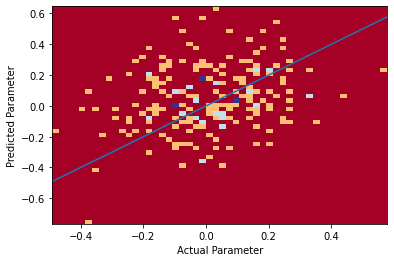

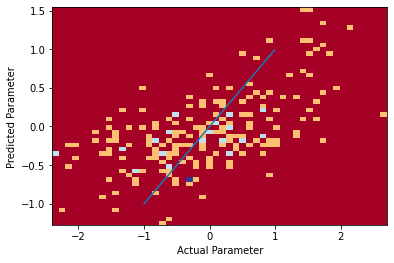

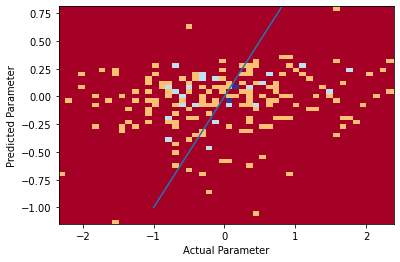

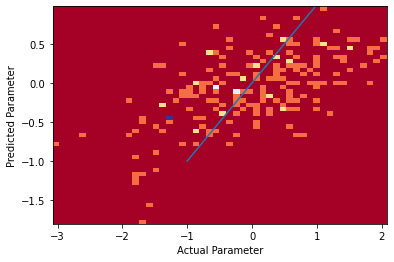

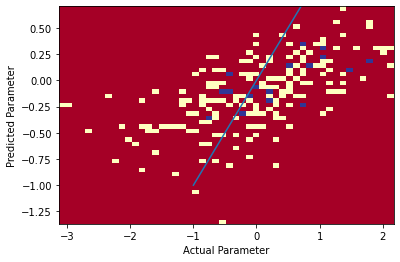

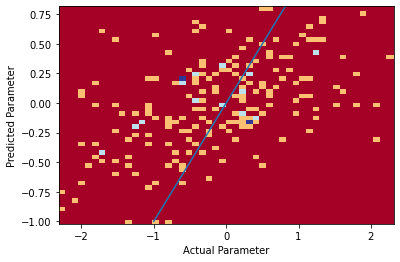

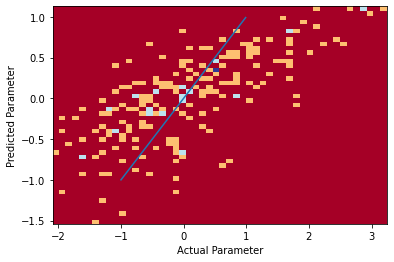

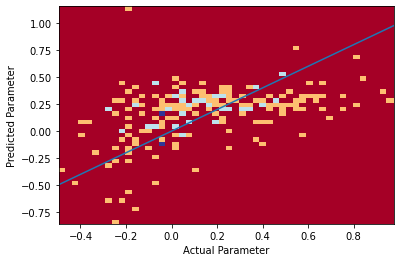

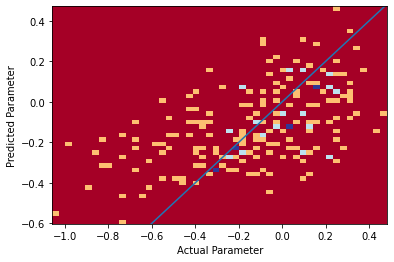

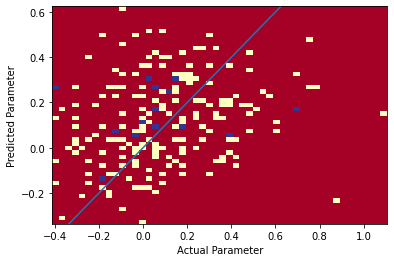

In [13]:
from matplotlib import cm

for i in range(15):
  plt.hist2d(ytest[:,i],Y_hat[:,i],bins=50,cmap=cm.RdYlBu)
  plt.xlabel('Actual Parameter')
  plt.ylabel('Predicted Parameter')
  plt.plot(np.arange(-1,1,0.01),np.arange(-1,1,0.01))
  plt.show()

[-0.183, -0.147, -0.288, -0.578, -0.19, -0.994, 0.343, 0.031, 0.345, 0.266, 0.209, 0.463, 0.021, 0.275, -0.198]


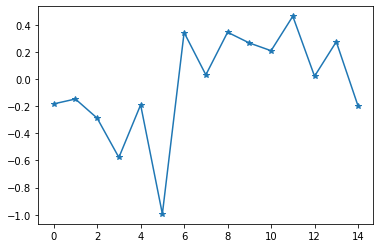

In [14]:
R2=[]
from sklearn.metrics import r2_score 
for i in range(15):
  R2.append(np.round(r2_score(ytest[:,i], Y_hat[:,i]),3))
print(R2)
plt.plot(R2,marker='*')